Here we will demonstrate how to run Partial Least Squares in the context of the office study.

In [1]:
import pandas as pd
import matplotlib
import rpy2
import numpy as np

%load_ext rpy2.ipython

First let's open up the feature tables for the OTUs and the mass spectra in addition to the mapping file.

In [2]:
mapping = pd.read_table('../data/qiita_mapping.txt', index_col=0)
microbes = pd.read_csv('../data/16S_features.csv', index_col=0)
metabolites = pd.read_csv('../data/MS1_features.csv', index_col=0)

In this particular, we will focus on people in this study.  To reduce runtime and sparsity, we will filter out all 
low abundance species and molecules.

In [3]:
mapping = mapping.loc[mapping.host_scientific_name=='Homo sapiens']

mapping, microbes = mapping.align(microbes, join='inner', axis=0)
mapping, metabolites = mapping.align(metabolites, join='inner', axis=0)
microbes, metabolites = microbes.align(metabolites, join='inner', axis=0)

microbes = microbes.loc[:, microbes.sum(axis=0) > 500]
microbes = microbes.loc[:, microbes.var(axis=0) > 1000]
microbes = microbes.loc[:, (microbes>0).sum(axis=0) > 5]

metabolites = metabolites.loc[:, metabolites.sum(axis=0) > 500000]
metabolites = metabolites.loc[:, metabolites.var(axis=0) > 50000000]
metabolites = metabolites.loc[:, (metabolites>0).sum(axis=0) > 5]

# fix the names for reading into R.
metabolites.columns = list(map(lambda x: "X%s" % x.replace(' ', '.'), metabolites.columns))

Now we will be depositing these files to csv so that we can read them for the indicator analyses.
Essentially, this is a frequentist approach for classifying features to different classes.
Here, we will try to use it to identify unique molecules and microbes for each volunteer.

In [4]:
microbes.to_csv('filtered_16S.csv')
metabolites.to_csv('filtered_MS.csv')
mapping.to_csv('r_mapping.csv')

Run the following code block only if you have r-magic installed.
Otherwise, run `indval.R` separately (assuming that R, rpy2 and labdsv are installed).  
Note that this is only important for coloring the points and arrows in the biplot.

In [5]:
%%R 
library(labdsv)
table_ms <- read.csv('filtered_MS.csv', row.names=1, header=TRUE, check.names=FALSE)
table_16s <- read.csv('filtered_16S.csv', row.names=1, header=TRUE, check.names=FALSE)
mapping <- read.csv('r_mapping.csv')
metabolite.iv <- indval(table_ms, as.numeric(mapping$subject), numitr=1000)
microbe.iv <- indval(table_16s, as.numeric(mapping$subject), numitr=1000)

gr <- microbe.iv$maxcls
iv <- microbe.iv$indcls
pv <- microbe.iv$pval
microbe.summary <- data.frame(group=gr, indval=iv, pval=pv)
write.table(microbe.summary, 'microbe.indicator.values.csv', sep=',')

gr <- metabolite.iv$maxcls
iv <- metabolite.iv$indcls
pv <- metabolite.iv$pval
metabolite.summary <- data.frame(group=gr, indval=iv, pval=pv)
write.table(metabolite.summary, 'metabolite.indicator.values.csv', sep=',')

/Users/mortonjt/miniconda3/envs/pls-tutorial/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: mgcv

  warnings.warn(x, RRuntimeWarning)
/Users/mortonjt/miniconda3/envs/pls-tutorial/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: nlme

  warnings.warn(x, RRuntimeWarning)
/Users/mortonjt/miniconda3/envs/pls-tutorial/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: This is mgcv 1.8-17. For overview type 'help("mgcv-package")'.

  warnings.warn(x, RRuntimeWarning)
/Users/mortonjt/miniconda3/envs/pls-tutorial/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: MASS

  warnings.warn(x, RRuntimeWarning)
/Users/mortonjt/miniconda3/envs/pls-tutorial/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: cluster

  warnings.warn(x, RRuntimeWarning)
/Users/mor

First you'll need to run indval.R separately.  Once that's done, we can load up the results of the indicator analysis.

In [6]:
microbe_iv = pd.read_csv('microbe.indicator.values.csv', index_col=0)
metabolite_iv = pd.read_csv('metabolite.indicator.values.csv', index_col=0)

We will only consider the most obvious classifications, in this case the molecules and microbes that have a pvalue of less than 0.001

In [7]:
microbe_iv.loc[microbe_iv.pval>0.001, 'group'] = 'None'
microbe_iv['volunteer'] = microbe_iv['group'].astype(np.str)

metabolite_iv.loc[metabolite_iv.pval>0.001, 'group'] = 'None'
metabolite_iv['volunteer'] = metabolite_iv['group'].astype(np.str)

Now, let's run the actual partial least squares.

In [8]:
from sklearn.cross_decomposition import PLSSVD
from skbio.stats.composition import clr, centralize, multiplicative_replacement
plssvd = PLSSVD(n_components=2)
# clr(centralize(...)) just does a double centering of the log abundances
# its basically what you do before running pcoa
plssvd.fit(X=clr(centralize(multiplicative_replacement(microbes))),
           Y=clr(centralize(multiplicative_replacement(metabolites))))

PLSSVD(copy=True, n_components=2, scale=True)

We will want to standardize the means, so let's create a function for it.

In [9]:
def standardize(A):
    A = (A - np.mean(A, axis=0)) / np.std(A, axis=0)
    return A

In [10]:
pls_microbes = pd.DataFrame(standardize(plssvd.x_weights_), 
                            columns=['PCA1', 'PCA2'], index=microbes.columns)
pls_metabolites = pd.DataFrame(standardize(plssvd.y_weights_), 
                               columns=['PCA1', 'PCA2'], index=metabolites.columns)

Now we wil make the biplot.

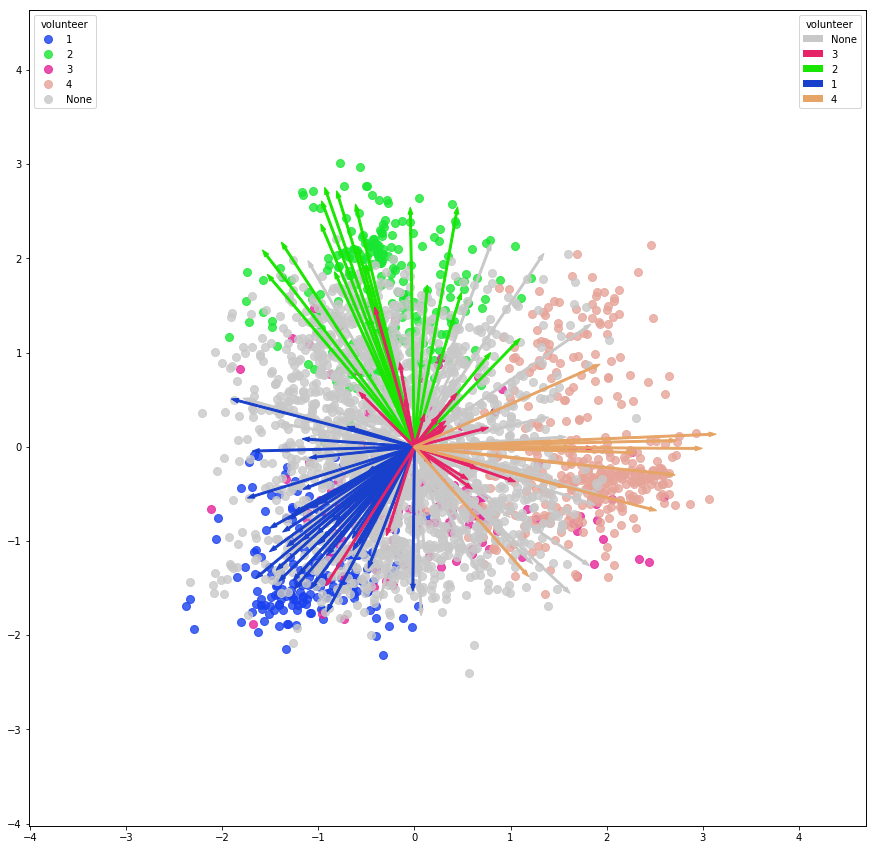

In [11]:
from biplot import make_biplot
%matplotlib inline
_ = make_biplot(pls_metabolites, pls_microbes, 
                sample_metadata=metabolite_iv,
                feature_metadata=microbe_iv, 
                sample_color_category='volunteer',
                feature_color_category='volunteer', feature_order=1,
                samp_alpha=0.8,
                sample_color_dict={'1': '#1940EE', '2': '#19E633', '3': '#E62399', '4': '#E6A499', 'None': '#C8C8C8'},
                feature_color_dict={'1':'#1940CC', '2': '#19E600', '3': '#E62366', '4': '#E6A466', 'None': '#C8C8C8'},
                feature_zorder={'1': 1, '2': 2, '3': 3, '4': 4, 'None': 0}
)

Each arrow represents a microbes and each dot represents a molecule. Arrows close together approximate the correlations between microbes.  Samples close together approximate correlations between metabolites.  Arrows bisecting clouds of points indicate that those microbes could be explaining the variation between the metabolites.